<h1><center>RATING THE CRITICS</center></h1>
<h2><center> Assessing the Impact and Bias of the New York Times' Film Critics and the Academy of Motion Picture Arts and Sciences</center></h2>
<br>
<center>University of Toronto - STA2453 - 11/1/2018</center>
<center>**David Veitch** - 1004657017</center>








In this report I seek to answer three questions:

* **Are film critics from the New York Times (NYT) able to predict box office hits?**
* **What kind of storylines do NYT critics favour?**
* **What best picture nominees tend to win Oscars, and does this differ from audience preferences?**

**Preliminaries**

[Introduction](#introduction)

[Data Collection](#datacollection)

**Analysis**

* [1. Are film critics from the NYT able to predict box office hits?](#question1)

* [2. What kind of storylines do the NYT critics favour?](#question2)

* [3.What best picture nominees tend to win Oscars, and does this differ from audience preferences?](#question3)

**Conclusion**

[Conclusion](#conclusion)

<a id='introduction'></a>
# INTRODUCTION

This analyses considers three related questions.

**1. Are film critics from the NYT able to predict box office hits?**: This analysis considers movies from the past forty years that have been reviewed in the NYT and tests whether NYT critics' picks are associated with box office success. To determine if, controlling for other relevant variables, NYT Critics can pick box office hits, multiple linear regression and logistic regression are used.

**2. What kind of storylines do the NYT critics favour?**: This analysis also looks at movies from the past forty years reviewed by the NYT, specifically plot summaries of each movie. Classification trees are used to determine what plot characteristics increase the liklihood a given movie is rated as a critics' pick.

**3.What best picture nominees tend to win Oscars, and does this differ from audience preferences?**: This analysis considers all of the best picture nominees (beginning at 1962). Using a number of vizualizations we can see what type of movies tend to win best picture, and how these movies differ from other nominees.

<a id='datacollection'></a>
# DATA COLLECTION

The data collection process involved querying the [New York Times Movie Review API](https://developer.nytimes.com/movie_reviews_v2.json), the [Open Movie Database API](http://www.omdbapi.com/), and using publically available pre-cleaned datasets from [The Numbers](https://www.statcrunch.com/app/index.php?dataid=2188684) and the [MovieLens dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset/home).

Results from the API calls were written to CSV files which are read by this notebook. This was done in order to reduce the number of times the APIs had to be accessed. It was also done because some API calls had to be made over multiple days to get around the daily limits.

In [896]:
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import pandas as pd
import statsmodels.api as sm
import warnings
from pandas.io.json import json_normalize
from datetime import datetime  
from datetime import timedelta
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 5
pd.options.display.max_columns = 6
%matplotlib inline
%pprint

Pretty printing has been turned OFF


#### NYT Movie Review Data

This is an example query to get a decades worth of NYT movie reviews. Four queries in total occured (1978-1988, 1988-1998, 1998-2008, 2008-2018); each query was written to a CSV and then combined into <font color='red'>'NYTReviewDataMaster.csv'</font> in Microsoft Excel.

In [897]:
# Original Query to Pull Data from the NYT Movie Review API

# start_of_week = datetime(1978,1,1)
# end_of_week = datetime(1978,1,7)
# nyt_master_data_pull = pd.DataFrame()

# for week in range(530):
#     # Constructs URL based on start/end date of a given week
#     url = "https://api.nytimes.com/svc/movies/v2/reviews/search.json";
#     url += '?'
#     url += '&' + 'api-key' + '=' + "f192c8e016da48359ddd9772434ad63a"
#     url += '&' + 'opening-date' + '=' + start_of_week.strftime('%Y-%m-%d') + ";" + end_of_week.strftime('%Y-%m-%d')
#     df = pd.read_json(url, orient = 'records')
    
#     # Adds one week worth of movies to the master_df
#     nyt_master_data_pull = pd.concat([nyt_master_data_pull,json_normalize(df['results'])],sort=False)
    
#     # Increments the week
#     start_of_week = start_of_week + timedelta(7)
#     end_of_week = end_of_week + timedelta(7)
    
# nyt_master_data_pull.to_csv('NYTReviewData4.csv', encoding='utf-8', index=False)

nyt_data = pd.read_csv('NYTReviewDataMaster.csv')
nyt_data

,byline,critics_pick,date_updated,...,opening_date,publication_date,summary_short
0,VINCENT CANBY,0,11/2/2017 4:17,...,1/6/1978,3/31/1978,James Dean's death affects a Southern student....
1,VINCENT CANBY,0,11/2/2017 4:17,...,1/6/1978,2/2/1978,"Boston hospital murders. Good, twisty thriller."
...,...,...,...,...,...,...,...
10143,MANOHLA DARGIS,1,1/12/2018 17:44,...,12/15/2017,12/12/2017,"With charm and wit, the latest “Star Wars” mov..."
10144,BEN KENIGSBERG,0,12/22/2017 17:44,...,12/13/2017,12/12/2017,The documentary by Petra Lataster-Czisch and P...


#### MovieLens Dataset

Kaggle hosts a CSV of the MovieLens Dataset here (https://www.kaggle.com/rounakbanik/the-movies-dataset/home). This contains information on 45,000 movies before July 2017. The benefit of this dataset is it contains information on movie budgets and revenues. The data is imported from <font color='red'>'movies_metadata.csv'</font>

In [898]:
movielens_database = pd.read_csv('movies_metadata.csv')
movielens_database

,adult,belongs_to_collection,budget,...,video,vote_average,vote_count
0,False,NaN,0,...,False,10.0,1.0
1,False,NaN,0,...,False,10.0,3.0
...,...,...,...,...,...,...,...
45464,FALSE,"{'id': 122661, 'name': 'Mardock Scramble Colle...",0,...,NaN,NaN,NaN
45465,FALSE,NaN,0,...,NaN,NaN,NaN


#### Budget & Revenue Data (The Numbers)

Budget & Revenue information from The Numbers was publically available in CSV format. It is imported from <font color='red'>'MovieRevenueAndBudget.csv'</font>

In [899]:
budget_revenue = pd.read_csv('MovieRevenueAndBudget.csv',encoding = "ISO-8859-1")
budget_revenue = budget_revenue.rename(columns={'Movie': 'display_title','Worldwide Gross($M)':'WorldwideGross',
                                               'Budget($M)':'Budget','Domestic Gross($M)':'DomesticGross'})

#### OMDB API
Import data from OMDB as <font color='red'>'OscarNomineeOMBD.csv'</font>. An example API call can be found in question 3.

In [900]:
omdb_df = pd.read_csv('OscarNomineeOMBD.csv')

#### Oscar Nominees

A list of Oscar Nominees for best picture going back to 1962 was found at [https://datahub.io/rufuspollock/oscars-nominees-and-winners](https://datahub.io/rufuspollock/oscars-nominees-and-winners).

In [901]:
oscar_data = pd.read_csv('OscarNominees.csv')

<a id='question1'></a>
# 1. Are film critics from the NYT able to predict box office hits?

Some exploratory data analysis on some factors that may affect box office revenue (measured as Worldwide Gross earnings) are plotted below.

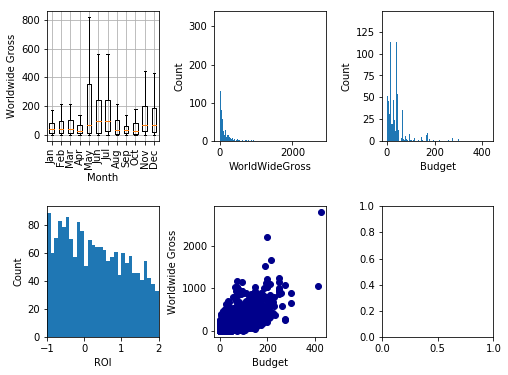

In [902]:
# Merge Budget and Revnue Data with NYT data
result = pd.merge(nyt_data, budget_revenue, on=['display_title'])
result['Budget'] = pd.to_numeric(result['Budget'], errors='coerce')
result = result[(result['Budget']>0) & (result['WorldwideGross']>0)]
result['ROI'] = result.eval('WorldwideGross/Budget-1')
result = result.set_index('display_title')

# Some movies have the exact same title which we are not able to differentiate which is which, we will throw these out ~200 movies
result = result[~result.index.duplicated(keep=False)]

bxplot_data = [result[result['Month']=='Jan']['WorldwideGross'],
              result[result['Month']=='Feb']['WorldwideGross'],
              result[result['Month']=='Mar']['WorldwideGross'],
              result[result['Month']=='Apr']['WorldwideGross'],
              result[result['Month']=='May']['WorldwideGross'],
              result[result['Month']=='Jun']['WorldwideGross'],
              result[result['Month']=='Jul']['WorldwideGross'],
              result[result['Month']=='Aug']['WorldwideGross'],
              result[result['Month']=='Sep']['WorldwideGross'],
              result[result['Month']=='Oct']['WorldwideGross'],
              result[result['Month']=='Nov']['WorldwideGross'],
              result[result['Month']=='Dec']['WorldwideGross']]


fig, (ax1, ax2) = plt.subplots(2, 3,figsize=(8,6))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

ax1[0].boxplot(bxplot_data,showfliers=False)
ax1[0].set_xlabel('Month')
ax1[0].set_xticklabels(labels=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],rotation = 90)
ax1[0].set_ylabel('Worldwide Gross')
ax1[0].grid(True)

ax1[1].hist(result['WorldwideGross'],bins=500)
ax1[1].set_xlabel('WorldWideGross')
ax1[1].set_ylabel('Count')

ax1[2].hist(result['Budget'],bins=500)
ax1[2].set_xlabel('Budget')
ax1[2].set_ylabel('Count')

ax2[0].hist(result['ROI'],bins=5000)
ax2[0].set_xlim(-1,2)
ax2[0].set_xlabel('ROI')
ax2[0].set_ylabel('Count')

ax2[1].scatter(x='Budget',y='WorldwideGross',c='DarkBlue',data=result)
ax2[1].set_xlabel('Budget')
ax2[1].set_ylabel('Worldwide Gross')

plt.show()

<a id='section2'></a>

#### Method 1 - Multiple Linear Regression

A standard multiple linear regression model was fit to the data (movies the NYT reviewed, where budget and revenue data also existed).

For any given movie the response variable was Worldwide Gross and the explanatory variables included: budget, critics' pick (1 if yes 0 if no), and dummy variables for movie rating and month.

Not all of the dummy explanatory variables appear to be statistically significant. That being said given certain subsets of dummy variables are undoubtedly significant, and there is an underlying intuition as to why they would affect movie revenue (e.g. Christmas movies tend to be big releases, and rated R movies tend to make less given the smaller potential crowd), all dummy variables are kept.

In [903]:
X_cols = ['Budget','critics_pick']
X = result[X_cols]
X = sm.add_constant(X)

# add rating dummy variables
rating_dummies = pd.get_dummies(result['mpaa_rating'])
X = pd.merge(X, rating_dummies, on='display_title',how='inner')

# add month dummy variables
month_dummies = pd.get_dummies(result['Month'])
X = pd.merge(X, month_dummies, on='display_title',how='inner')
y = result['WorldwideGross']

least_squares = sm.OLS(y, X)

# Drop large residuals associated with these three movies
X = X.drop(['Titanic','Avatar','Pirates of the Caribbean: On Stranger Tides'])
y = y.drop(['Titanic','Avatar','Pirates of the Caribbean: On Stranger Tides'])

#fit the model
model1 = least_squares.fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         WorldwideGross   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     186.0
Date:                Thu, 01 Nov 2018   Prob (F-statistic):               0.00
Time:                        22:56:24   Log-Likelihood:                -17744.
No. Observations:                2837   AIC:                         3.553e+04
Df Residuals:                    2816   BIC:                         3.565e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           21.6014     12.465      1.733   

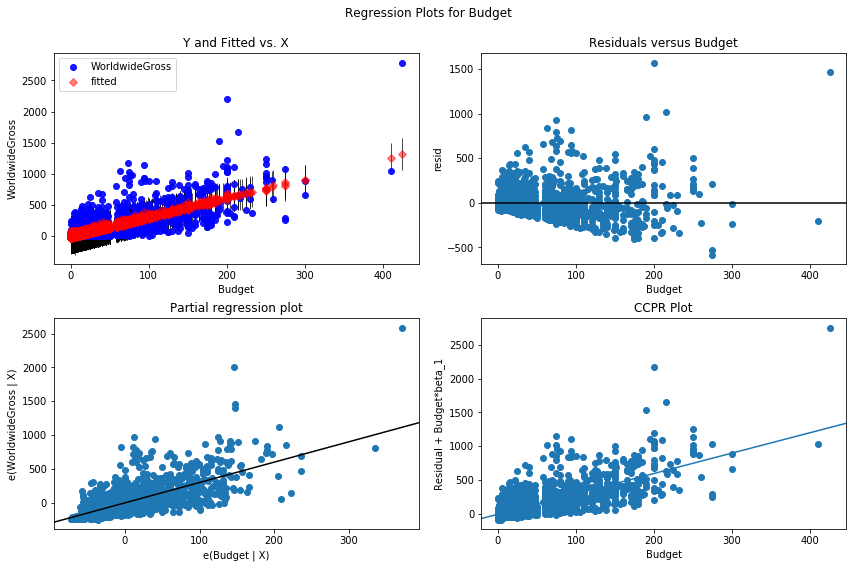

In [904]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model1, "Budget", fig=fig)
plt.show()

#### Conclusion 1 - Multiple Linear Regression

Observing the Critics' Pick variable in the regression we notice it is statistically significant and is positively associated with movies' Worldwide Gross totals. Based on this test **it appears NYT critics are successful at choosing box office hits.**

#### Method 2 - Logistic Regression

This analysis asks a slightly different question. Specifically are NYT critics able to discern what films will be financially successful. Here we define financially successful as ROI, the percentage return a film makes based on its budget. Given ROIs for small movies can be very erratic we restrict our analysis to movies with a budget of at least 50mm, and define successful as being in the top 25% of films in this category by ROI.

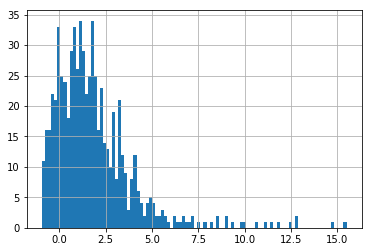

In [905]:
big_films = result[result['Budget']>50]
big_films['ROI'].hist(bins=100)

In [906]:
big_films['Success']=pd.get_dummies(big_films['ROI']>big_films['ROI'].quantile(.75))[True]

X2 = big_films[['critics_pick']]
X2 = sm.add_constant(X2)
y2 = big_films['Success'].values

model2 = sm.Logit(y2,X2)
logit_res = model2.fit()
print(logit_res.summary2())

Optimization terminated successfully.
         Current function value: 214.899744
         Iterations 5
                          Results: Logit
Model:              Logit            No. Iterations:   5.0000     
Dependent Variable: y                Pseudo R-squared: -0.023     
Date:               2018-11-01 22:57 AIC:              290118.6540
No. Observations:   675              BIC:              290127.6834
Df Model:           1                Log-Likelihood:   -1.4506e+05
Df Residuals:       673              LL-Null:          -1.4173e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const         -1.2040    0.0992  -12.1320  0.0000  -1.3985  -1.0095
critics_pick   0.6252    0.2281    2.7411  0.0061   0.1782   1.0723



#### Conclusion 2 - Logistic

Logistic regression shows us a fairly **significant positive association between critics' picks financial success**. For movies that are critics' picks 56% of them are financially successful, for movies that are not critics' picks only 30% are financially successful. 

<a id='plotclass'></a>

<a id='question2'></a>
# 2. What kind of storylines do the NYT critics favour?

#### Method 1 - Classification Trees Unigrams

In order to determine what type of storylines the NYT critics favour we utilize classification trees. First we vectorize each movie's plot description based on the words contained in it. For example if MovieA's plot is 'Dog runs away' and MovieB's plot is 'Dog bites man' the vectorized representation of these would be. Each movie also has a label (1 if it is a critics pick, 0 if not).

<br>

<center>
$
\begin{bmatrix}
     & dog & runs & away  & bites & man \\
    MovieA & 1 & 1 & 1  & 0 & 0 \\
    MovieB & 1 & 0 & 0  & 1 & 1
\end{bmatrix}
$
</center>

It is worth noting that the vectorizer discards a number of 'stop words' that have limited information (e.g. and, or, in, on).

Using entropy (a measure of how equally distributed a set of movies are between critics picks and not critics picks) the classification tree will at each step select a word that appears to do a good job of explaining if a given movie is a critics pick or not, and splits the data based on movies that contain this word in their plot and those that do not. By observing the top levels of the classification tree the analysis shows which words are **most informative** as to whether a movie will be a critics pick.

In [907]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import string
import pydotplus
import graphviz
from IPython.display import Image  

In [908]:
movie_plot_df = movielens_database
movie_plot_df = movie_plot_df[['title','overview']]
movie_plot_df = movie_plot_df.rename(columns={'title': 'display_title'})
nyt_bare_bones = nyt_data[['display_title','critics_pick','opening_date']]
nyt_plot_picks = pd.merge(nyt_bare_bones,movie_plot_df,on=['display_title'])
nyt_plot_picks = nyt_plot_picks.set_index('display_title')
nyt_plot_picks = nyt_plot_picks[~nyt_plot_picks.index.duplicated(keep=False)]
nyt_plot_picks['overview'] = nyt_plot_picks['overview'].str.lower()

In [909]:
# Certain words are discarded based on being relatively uninformative
my_stop_words = text.ENGLISH_STOP_WORDS.union(['come','san','film'])

vectorizer = CountVectorizer(stop_words=my_stop_words)
corpus = vectorizer.fit_transform(nyt_plot_picks['overview'].values.astype('U'))
model_feature_names = vectorizer.get_feature_names()

X_tree = corpus
y_tree = nyt_plot_picks['critics_pick'].values

clf = DecisionTreeClassifier(random_state=1,criterion='entropy',max_depth=7)
model = clf.fit(X_tree,y_tree)

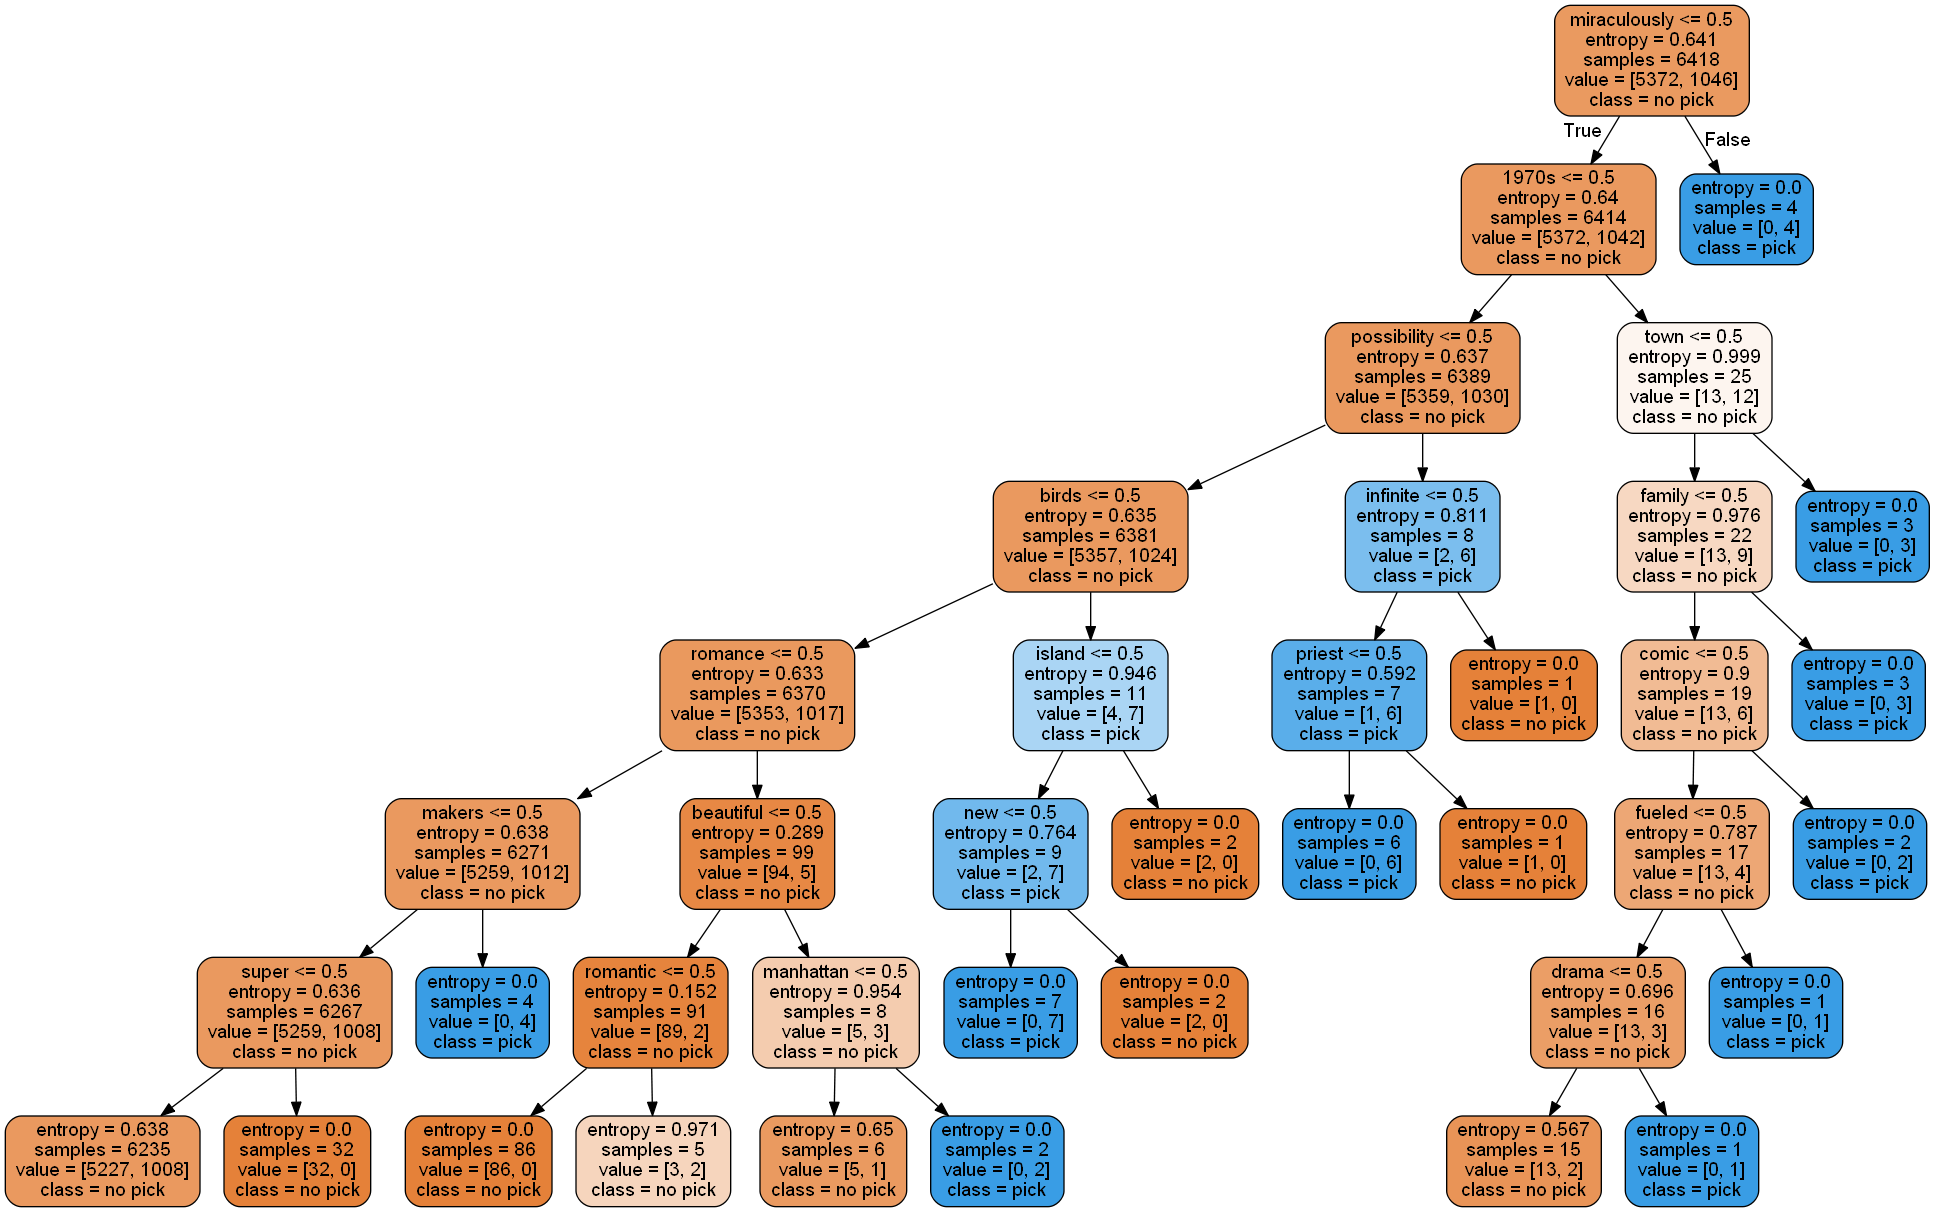

In [910]:
# Print the classification tree
dot_data = tree.export_graphviz(clf, filled=True,rounded=True,out_file=None,
                                feature_names=model_feature_names,class_names=['no pick','pick'])
    
graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

#### Conclusion 1 - Classification Trees Unigrams

A few interesting themes emerge, which point to the type of movies critics like. For context approximately 14% of movies are deemed critics picks.

**Stories which contains the words 'miraculous', '1970s', 'birds' are overrepresented in critics picks**. Also interesting is that stroies with plots containing 'romance', 'beautiful', and 'manhattan' fare well; given the NYT's location this is somewhat unsurprising.

It is worth noting that the design matrix is very sparse since only approximately 3% of the movies in the dataset contain any of the words listed at all in the first 7 layers of this tree.

#### Method 2 - Classification Trees Bigrams

The analysis is repeated using bigrams. In this method the classification tree looks to split on pairs of words. For example the movie 'Dog bites man' would be vectorized as \['dog bites', 'bites man'\]

In [911]:
movie_plot_df3 = movielens_database
movie_plot_df3 = movie_plot_df3[['title','overview']]
movie_plot_df3 = movie_plot_df3.rename(columns={'title': 'display_title'})
nyt_bare_bones = nyt_data[['display_title','critics_pick','opening_date']]

nyt_plot_picks2 = pd.merge(nyt_bare_bones,movie_plot_df3,on=['display_title'])
nyt_plot_picks2 = nyt_plot_picks2.set_index('display_title')
nyt_plot_picks2 = nyt_plot_picks2[~nyt_plot_picks2.index.duplicated(keep=False)]
nyt_plot_picks2['overview'] = nyt_plot_picks2['overview'].str.lower()

In [912]:
from sklearn.feature_extraction import text 

my_stop_words = text.ENGLISH_STOP_WORDS.union(['come','san','film','oscar','nominated'])
vectorizer = CountVectorizer(stop_words=my_stop_words,analyzer='word',ngram_range=(2, 2))

corpus = vectorizer.fit_transform(nyt_plot_picks2['overview'].values.astype('U'))

model_feature_names = vectorizer.get_feature_names()

X_tree = corpus
y_tree = nyt_plot_picks2['critics_pick'].values

clf = DecisionTreeClassifier(random_state=1,criterion='entropy',max_depth=25)
model = clf.fit(X_tree,y_tree)

The classification tree is very deep (25 layers) to try and find out as many useful bigrams as possible. We do not print the tree for this reason (it is too big).

In [913]:
# # Print the classification tree
# dot_data = tree.export_graphviz(clf, filled=True,rounded=True,out_file=None,
#                                 feature_names=model_feature_names,class_names=['no pick','pick'])
    
# graph = pydotplus.graph_from_dot_data(dot_data)

# Image(graph.create_png())

In [914]:
ftr_importances = model.feature_importances_
B = [a>.01]
important_feature_idx = np.where(ftr_importances >0.01)
important_feature_idx = important_feature_idx[0].tolist()

important_features=[]

for ftr_idx in important_feature_idx:
    important_features.append(model_feature_names[ftr_idx])

important_features

['20th century', 'al gore', 'andy toys', 'anti semitism', 'big sur', 'boy living', 'chaotic world', 'day year', 'eighty year', 'encounter leads', 'events involving', 'journey ancient', 'khmer rouge', 'kill batch', 'lives america', 'lives rock', 'loss mother', 'man dies', 'martial arts', 'north london', 'offers glimpse', 'prepares legendary', 'rock roll', 'series events', 'series flashbacks', 'smooth talking', 'trade center', 'upper middle', 'wedding anniversary', 'wishes mother']

#### Conclusion 2 - Classification Trees Bigrams

Bigrams give a different perspective on what leads a movie to be a critics pick. Most of these bigrams are associated with movies that, if they contain them in their plot, are critics pick. **Some particurlarly interesting plots that NYT are biased towards include big sur, anti semitism, al gore, and smooth talking.** 

<a id='question3'></a>
# 3. What best picture nominees tend to win Oscars, and does this differ from audience preferences?

We analyze the Oscar data in several ways.

1. How are best picture nominated movies rated by users of IMDB and how does this compare with what movie actually wins.
2. What are the characteristics (runtime and genre) of movies that do not win.

#### Method 1 - Are Oscar Best Picture Winners Always the Highest Rated By IMDB Users?

In [915]:
oscar_data = oscar_data[oscar_data['category']=='BEST PICTURE']

# Remove movies that OMDB does not have
oscar_data = oscar_data[oscar_data['entity'] != 'Meredith Willson\'s The Music Man']
oscar_data = oscar_data[oscar_data['entity'] != 'Cries and Whispers']
oscar_data = oscar_data[oscar_data['entity'] != 'Good Fellas']
oscar_data = oscar_data[oscar_data['entity'] != 'The Postman (Il Postino)']
oscar_data = oscar_data[oscar_data['entity'] != 'Les Misérables']
oscar_data = oscar_data.set_index('entity')
oscar_data = oscar_data.rename(columns={'year': 'oscar_year'})

movie_metadata = movielens_database
movie_metadata = movie_metadata.rename(columns={'original_title': 'entity'})
oscar_merged = pd.merge(oscar_data, movie_metadata, how='left', on=['entity'])
oscar_merged['release_year'] = pd.DatetimeIndex(oscar_merged['release_date']).year
oscar_merged['year_diff'] = oscar_merged['release_year'] - oscar_merged['oscar_year']
oscar_merged = oscar_merged[(np.absolute(oscar_merged['year_diff'])<2) | (oscar_merged['year_diff'].isnull())]
oscar_merged['release_year'] = oscar_merged['release_year'].fillna(0)
oscar_merged['release_year'] = oscar_merged['release_year'].astype(int)

# drop movies that got duplicated
oscar_merged = oscar_merged.drop([205,325])

oscar_loop = oscar_merged[['entity','oscar_year','release_year','winner']].values

# Loop to Get Oscar Movie info from OMDB, run once, wrote to CSV file

# omdb_df = pd.DataFrame()
# apikey_omdb = "ab8ac07e"

# for movie_title, oscar_year,release_year,winner in oscar_loop: 
#     movie = movie_title
#     title = 't=' + movie_title.replace(' ', '+')
    
#     if release_year == 0:
#         req = ('http://www.omdbapi.com/?apikey='+ apikey_omdb + '&'+ title + '&plot=full')
#         response = pd.read_json(req)
#         omdb_df = omdb_df.append(response.iloc[0])
#     else:
#         req = ('http://www.omdbapi.com/?apikey='+ apikey_omdb + '&'+ title + '&plot=full' + 'y='+ str(release_year))
#         response = pd.read_json(req)
#         omdb_df = omdb_df.append(response.iloc[0])
        
# omdb_df.to_csv('OscarNomineeOMBD.csv', encoding='utf-8', index=False)

omdb_df['winner'] = oscar_merged['winner'].values
omdb_df['release_year'] = oscar_merged['release_year'].values
omdb_df['oscar_year'] = oscar_merged['oscar_year'].values
omdb_df['Year']= pd.to_numeric(omdb_df['Year'], errors='coerce')
omdb_df['imdbVotes'] = omdb_df['imdbVotes'].str.replace(',','')
omdb_df['imdbVotes']= pd.to_numeric(omdb_df['imdbVotes'], errors='coerce')
omdb_df['Runtime'] = omdb_df['Runtime'].str.replace(' min','')
omdb_df['Runtime'] = pd.to_numeric(omdb_df['Runtime'],errors='coerce')

# remove movies that year is not right 
# this sometimes happens if OMDB not able to pull correct movie despite being given year and title
omdb_df = omdb_df[(omdb_df['release_year']==0) |(omdb_df['release_year']==omdb_df['Year'])]
omdb_df['release_year'] = omdb_df['Year']

# drop a random movie that comes out incorrectly
omdb_df = omdb_df.drop(21)

From the below chart we see that most of the time the movie that is highest rated by fans is also the movie that won best picture, however there are many instances where this is not true.

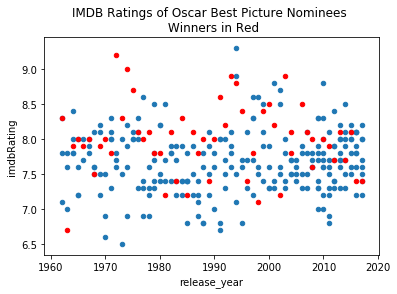

In [916]:
ax = omdb_df[omdb_df['winner']==False].plot(x='release_year',y='imdbRating',kind='scatter')
omdb_df[omdb_df['winner']==True].plot(x='release_year',y='imdbRating',kind='scatter',ax=ax,color='red',
                                      title='IMDB Ratings of Oscar Best Picture Nominees \n Winners in Red')

Another chart showing how most of the time the movie that wins is either the highest rated, or close to the highest rated, movie by fans.

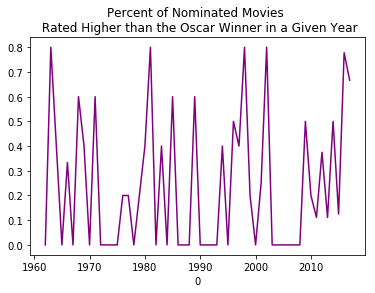

In [917]:
oscar_judge_score = []
loser_better_rating_master = pd.DataFrame()

for oscar_year in omdb_df['oscar_year'].unique():
    movies_in_year = omdb_df[omdb_df['oscar_year']==oscar_year]
    winner_rating = movies_in_year[movies_in_year['winner']==True]['imdbRating'].values[0]
    
    loser_count = movies_in_year[movies_in_year['winner']==False].shape[0]
    loser_better_rating = movies_in_year[(movies_in_year['winner']==False) & (movies_in_year['imdbRating']>winner_rating)]
    loser_better_rating_master = loser_better_rating_master.append(loser_better_rating)
    
    pct_movie_disenfranchied = loser_better_rating.shape[0]/movies_in_year.shape[0]
    
    oscar_judge_score.append([oscar_year,pct_movie_disenfranchied])
    
oscar_judge_score = pd.DataFrame(oscar_judge_score)
oscar_judge_score.plot(x=0,y=1,color='purple',
                       title='Percent of Nominated Movies \n Rated Higher than the Oscar Winner in a Given Year',legend=False)   

#### Conclusion 1 - Are Oscar Best Picture Winners Always the Highest Rated?
From our charts it appears that most of the time the movie that wins is the highest, or in the top two movies, rated by users of IMDB.

#### Method 2 - Characteristics of Movies that Were Nominated But Did Not Win Best Picture
To explore bias by the Oscar selection committee relative to the general public we look at characteristics of Best Picture winners versus those of movies that were rated more highly on IMDB than the Best Picture winner in the year they were nominated.

In [918]:
winner_master = omdb_df[omdb_df['winner']==True]
loser_master = omdb_df[omdb_df['winner']==False]

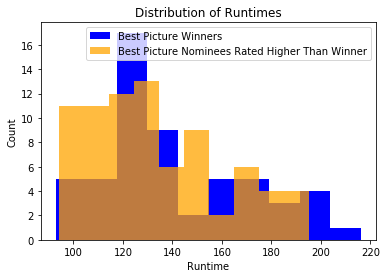

In [919]:
# Differences in Runtime
# winner_master['Runtime'].hist(alpha=1)
# loser_better_rating_master['Runtime'].hist(alpha = 0.5)

plt.hist(winner_master['Runtime'],color='blue')
plt.hist(loser_better_rating_master['Runtime'],color='orange',alpha=0.75)
plt.title('Distribution of Runtimes')
plt.xlabel('Runtime')
plt.ylabel('Count')
plt.legend(['Best Picture Winners','Best Picture Nominees Rated Higher Than Winner'])
plt.show()


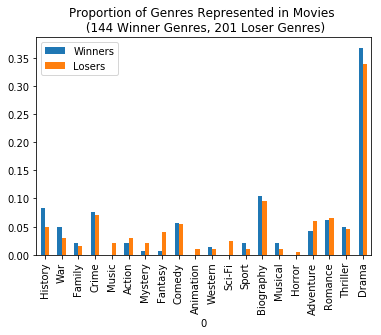

In [895]:
# Differences in Genres
genre_list = omdb_df['Genre'].tolist()
genre_list = ', '.join(genre_list)
genre_list = genre_list.replace(" ", "")
genre_list = genre_list.split(',')
unique_genres = set(genre_list)
unique_genres

genre_df = pd.DataFrame()
winner_genres = winner_master['Genre'].tolist()
winner_genres = ', '.join(winner_genres)
winner_genres = winner_genres.replace(" ", "")
winner_genres = winner_genres.split(',')
total_winner_genres = len(winner_genres)

loser_genres = loser_better_rating_master['Genre'].tolist()
loser_genres = ', '.join(loser_genres)
loser_genres = loser_genres.replace(" ", "")
loser_genres = loser_genres.split(',')
total_loser_genres = len(loser_genres)

for genre in unique_genres:
    genre_df = genre_df.append([[genre,
                                 winner_genres.count(genre)/total_winner_genres,
                                 loser_genres.count(genre)/total_loser_genres]])

genre_df = genre_df.set_index(0)
genre_df = genre_df.rename(columns={1: 'Winners',2:'Losers'})
genre_df.plot(kind='bar',title='Proportion of Genres Represented in Movies \n (144 Winner Genres, 201 Loser Genres)')
plt.show()

#### Conclusion 2 - Characteristics of Movies that Were Nominated But Did Not Win Best Picture
From both vizualisations it appears that the Oscar committee tends to be biased towards longer films, with genres in the History, War, or Drama category (while particularly avoiding films in the music, fantasy, or sci-fi category).

It is unsurprising that movies with long runtimes are not rated highly by the general public, some of the Oscar winners run over three hours which is an extremely long amount of time for a casual movie fan to get through.

<a id='conclusion'></a>
# CONCLUSION

In summary, the data was able to offer great insight into how critics at both the NYT and the Academy choose their favourite movies. Particularly we found that:

* NYT's critics do have a meaningful ability to predict what films will be box office hits.
* NYT critics are biased towards liking movies with certain plot themes. In particular they enjoy movies that have plots containing the words: 'miraculously', '1970s', 'birds'; or phrases like: 'big sur', 'anti semitism', 'al gore', and 'smooth talking'.
* The Academy does have a tendency to pick the movie which IMDB users also like, however they are biased towards choosing longer movies that are of the history, war or drama category; the academy also seems to particularly dislike music, fantasy, or sci-fi movies.